## Data Processing

In [1]:
import pandas as pd

def __merge(customer_filename: str, transaction_filename:str, fraud_filename:str):

    # Read and process files
    customer_release_df = pd.read_csv(customer_filename)
    fraud_release_df = pd.read_json(fraud_filename, orient='index')
    fraud_release_df = fraud_release_df.reset_index()
    fraud_release_df.columns = ['trans_num','is_fraud']
    transactions_release_df = pd.read_parquet(transaction_filename)
    transactions_release_df = transactions_release_df.reset_index()

    # Merge dataframes
    transactions_fraud_df = pd.merge(transactions_release_df, fraud_release_df, on='trans_num', how='inner')
    final_df = pd.merge(transactions_fraud_df,customer_release_df,on='cc_num',how='inner')
    final_df = final_df.sort_values('trans_date_trans_time')
    final_df = final_df.drop(columns=['index_x', 'index_y'])
    
    return final_df

In [2]:
customer_file = "../data_sources/customer_release.csv"
transactions_file = "../data_sources/transactions_release.parquet"
fraud_file = "../data_sources/fraud_release.json"

final_df = __merge(customer_file, transactions_file, fraud_file)

## Analyst Insights

### Anaylst Insight #1: The frequency of fraudulent transactions depends on the hour of the day the transaction occurs 

**Analysis**

It is clear that the hour of the day has a statistically significant influence on the number and percent of fraudulent transactions that occur. Visually we can see that fraudulent transaction activity is highest during night hours.

In [3]:
# Convert trans_date_trans_time to datetime 
final_df['trans_date_trans_time'] = pd.to_datetime(final_df['trans_date_trans_time'])

# Extract Hour of Day
final_df['hour_of_day'] = final_df['trans_date_trans_time'].dt.hour

# Create Fraud Freq Df
fraud_freq_by_time_df = final_df.groupby('hour_of_day').agg(total_transactions=('trans_num','size'), fraud_count=('is_fraud','sum')).reset_index()
fraud_freq_by_time_df['percent_fraud'] = (fraud_freq_by_time_df['fraud_count'] / fraud_freq_by_time_df['total_transactions'])*100
fraud_freq_by_time_df['non_fraud_count'] = fraud_freq_by_time_df['total_transactions'] - fraud_freq_by_time_df['fraud_count']

In [4]:
fraud_freq_by_time_df

,hour_of_day,total_transactions,fraud_count,percent_fraud,non_fraud_count
0,0,53253,568.0,1.066607,52685.0
1,1,53897,569.0,1.055717,53328.0
2,2,53537,566.0,1.057213,52971.0
3,3,53540,547.0,1.021666,52993.0
4,4,52639,46.0,0.087388,52593.0
5,5,52894,58.0,0.109653,52836.0
6,6,53165,38.0,0.071476,53127.0
7,7,53140,47.0,0.088446,53093.0
8,8,53256,43.0,0.080742,53213.0
9,9,53024,42.0,0.079209,52982.0


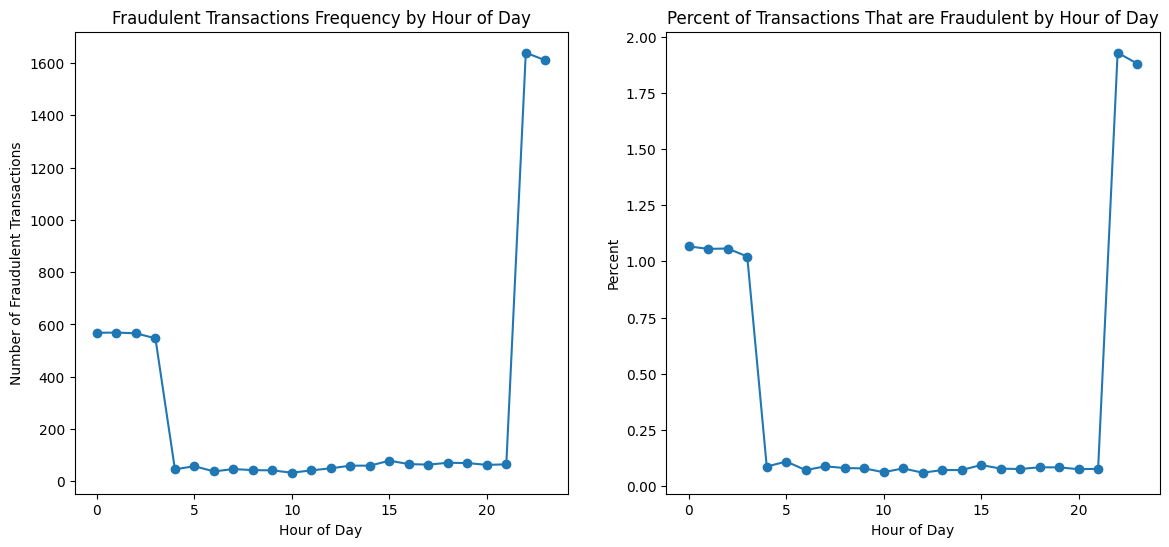

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Plotting the first graph (Fraud Count)
axs[0].plot(fraud_freq_by_time_df['hour_of_day'], fraud_freq_by_time_df['fraud_count'], marker='o')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Number of Fraudulent Transactions')
axs[0].set_title('Fraudulent Transactions Frequency by Hour of Day')

# Plotting the second graph (Percent Fraud)
axs[1].plot(fraud_freq_by_time_df['hour_of_day'], fraud_freq_by_time_df['percent_fraud'], marker='o')
axs[1].set_xlabel('Hour of Day')
axs[1].set_ylabel('Percent')
axs[1].set_title('Percent of Transactions That are Fraudulent by Hour of Day')

plt.show()


In [6]:
import scipy.stats as stats

contingency_table = fraud_freq_by_time_df[['fraud_count', 'non_fraud_count']].values
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

Chi-Square Statistic: 15456.081718399679
P-Value: 0.0


In [7]:
if p < 0.05:
    print("There is a significant association between the time of day and the likelihood of fraud.")
else:
    print("There is no significant association betweenthe time of day and the likelihood of fraud.")

There is a significant association between the time of day and the likelihood of fraud.


### Anaylst Insight #2: The frequency of fraudulent transactions depends on the day of week the transaction occurs

**Analysis**

While the chi-squared test does demonstrate that there is a statistical difference in fraudulant activity between days of the week, there does not appear to be too much of a trend in the data to demonstrate this conclusively. There is a small peak of percent fraudulant activity by the middle of the week but the difference in percent from other days is relatively very small. 

In [8]:
# Add day of week column to dataframe
final_df['day_of_week'] = final_df['trans_date_trans_time'].dt.day_of_week

# Create dataframe of fraudulent transactions grouped by day of week
fraud_freq_by_day_df = final_df.groupby('day_of_week').agg(total_transactions=('trans_num','size'), fraud_count=('is_fraud','sum')).reset_index()
fraud_freq_by_day_df['percent_fraud'] = (fraud_freq_by_day_df['fraud_count']/fraud_freq_by_day_df['total_transactions'])*100 
fraud_freq_by_day_df['non_fraud_count'] = fraud_freq_by_day_df['total_transactions'] - fraud_freq_by_day_df['fraud_count']
fraud_freq_by_day_df

,day_of_week,total_transactions,fraud_count,percent_fraud,non_fraud_count
0,0,328689,1034.0,0.314583,327655.0
1,1,240982,873.0,0.362268,240109.0
2,2,163610,778.0,0.475521,162832.0
3,3,183999,916.0,0.497829,183083.0
4,4,191012,899.0,0.470651,190113.0
5,5,233999,948.0,0.405130,233051.0
6,6,305251,1048.0,0.343324,304203.0


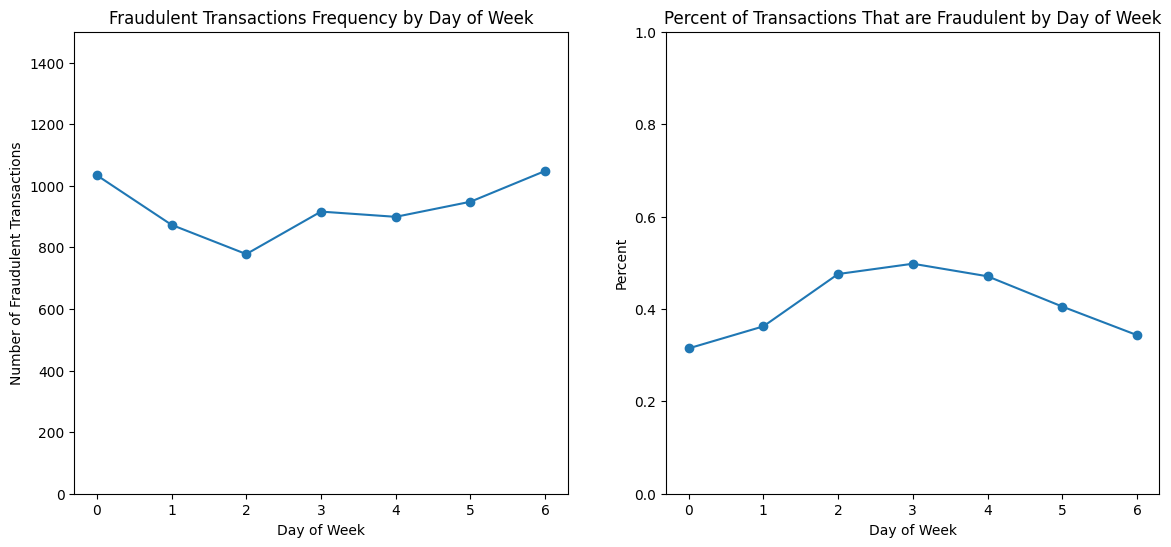

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Plotting the first graph (Fraud Count)
axs[0].plot(fraud_freq_by_day_df['day_of_week'], fraud_freq_by_day_df['fraud_count'], marker='o')
axs[0].set_xlabel('Day of Week')
axs[0].set_ylabel('Number of Fraudulent Transactions')
axs[0].set_title('Fraudulent Transactions Frequency by Day of Week')
axs[0].set_ylim([0,1500])

# Plotting the second graph (Percent Fraud)
axs[1].plot(fraud_freq_by_day_df['day_of_week'], fraud_freq_by_day_df['percent_fraud'], marker='o')
axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Percent')
axs[1].set_title('Percent of Transactions That are Fraudulent by Day of Week')
axs[1].set_ylim([0,1])

plt.show()

In [10]:
# Chi squared test

contingency_table = fraud_freq_by_day_df[['fraud_count', 'non_fraud_count']].values
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

Chi-Square Statistic: 186.42899015872885
P-Value: 1.4612130162322462e-37


In [11]:
if p < 0.05:
    print("There is a significant association between the day of the week and the likelihood of fraud.")
else:
    print("There is no significant association between the day of the week and the likelihood of fraud.")

There is a significant association between the day of the week and the likelihood of fraud.


### Analyst Insight #3: The frequency of fraudulent transactions depends the month the transaction occurs

**Analysis**

While the chi-squared test does demonstrate that there is a statistical difference in fraudulant activity between months of the year, there does not appear to be too much of a trend in the data to demonstrate this conclusively. 

In [12]:
# Add month column to dataframe
final_df['month'] = final_df['trans_date_trans_time'].dt.month

# Create dataframe of transactions grouped by month
fraud_freq_by_month_df = final_df.groupby('month').agg(total_transactions=('trans_num','size'), fraud_count=('is_fraud','sum')).reset_index()
fraud_freq_by_month_df['percent_fraud'] = (fraud_freq_by_month_df['fraud_count']/fraud_freq_by_month_df['total_transactions'])*100 
fraud_freq_by_month_df['non_fraud_count'] = fraud_freq_by_month_df['total_transactions'] - fraud_freq_by_month_df['fraud_count']
fraud_freq_by_month_df

,month,total_transactions,fraud_count,percent_fraud,non_fraud_count
0,1,93303,540.0,0.578760,92763.0
1,2,86821,560.0,0.645005,86261.0
2,3,127767,581.0,0.454734,127186.0
3,4,119974,433.0,0.360912,119541.0
4,5,130522,671.0,0.514090,129851.0
5,6,154633,549.0,0.355034,154084.0
6,7,153584,449.0,0.292348,153135.0
7,8,156494,581.0,0.371260,155913.0
8,9,124726,501.0,0.401680,124225.0
9,10,122877,555.0,0.451671,122322.0


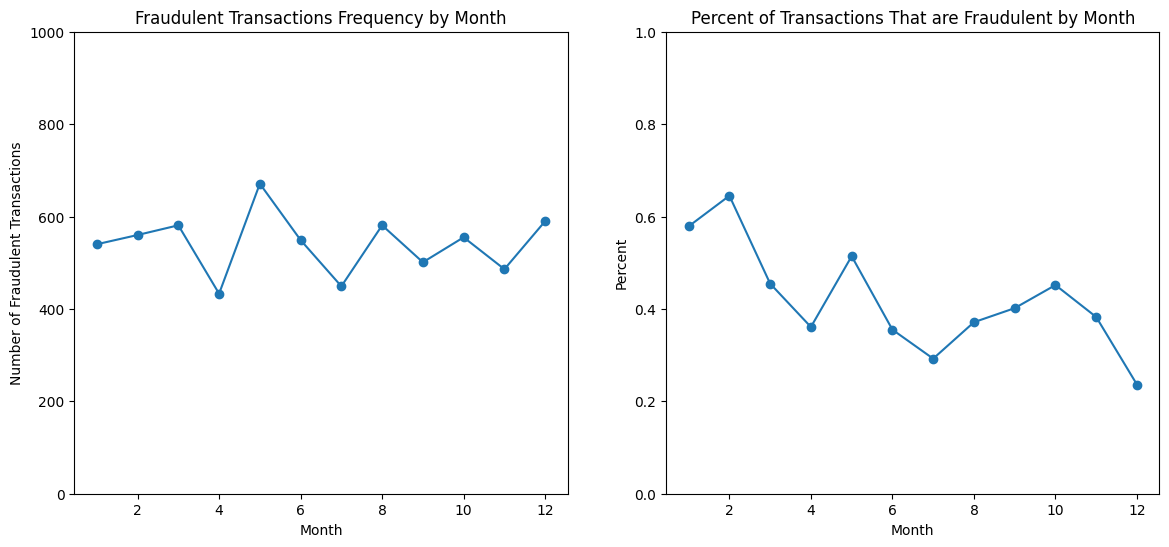

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Plotting the first graph (Fraud Count)
axs[0].plot(fraud_freq_by_month_df['month'], fraud_freq_by_month_df['fraud_count'], marker='o')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Number of Fraudulent Transactions')
axs[0].set_title('Fraudulent Transactions Frequency by Month')
axs[0].set_ylim([0, 1000])

# Plotting the second graph (Percent Fraud)
axs[1].plot(fraud_freq_by_month_df['month'], fraud_freq_by_month_df['percent_fraud'], marker='o')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Percent')
axs[1].set_title('Percent of Transactions That are Fraudulent by Month')
axs[1].set_ylim([0, 1])

plt.show()

In [14]:
# Chi-squared test
contingency_table = fraud_freq_by_month_df[['fraud_count', 'non_fraud_count']].values
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

Chi-Square Statistic: 501.46687284014
P-Value: 1.560571832524174e-100


In [15]:
if p < 0.05:
    print("There is a significant association between the month and the likelihood of fraud.")
else:
    print("There is no significant association between the month and the likelihood of fraud.")

There is a significant association between the month and the likelihood of fraud.


### Analyst Insight #4: Fraudulent transactions are likely to occur in quick succession

**Analysis**

There does appear to be a statistical difference in the distribution in time intervals between consecutive fraudulent and non-fraudulent tranactions. The average time interval between consecutive fraudulent transactions is lower than that of non-fraudulent transactions. This makes sense logically as culprits will likely try and use a stolen credit card as many times as possible before the victim/bank becomes aware and freezes the card.

In [16]:
# Sort the dataframe by customer and transaction time
final_df = final_df.sort_values(['cc_num', 'trans_date_trans_time'])

# Calculate the time diff between transactions
final_df['time_diff'] = final_df.groupby('cc_num')['trans_date_trans_time'].diff()

# Create fraudulent and non-fraudulent transactions dataframes
fraud_intervals_df = final_df[final_df['is_fraud'] == 1]['time_diff']
non_fraud_intervals_df = final_df[final_df['is_fraud'] == 0]['time_diff']

# Convert to minutes
fraud_intervals_df = fraud_intervals_df.dt.total_seconds() / 60
non_fraud_intervals_df = non_fraud_intervals_df.dt.total_seconds() / 60

In [17]:
fraud_intervals_df.describe()

count     6496.000000
mean       347.990184
std        566.431949
min          0.016667
25%         24.637500
50%         83.708333
75%        477.500000
max      14417.950000
Name: time_diff, dtype: float64

In [18]:
non_fraud_intervals_df.describe()

count    1.475701e+06
mean     4.794875e+02
std      6.911635e+02
min      0.000000e+00
25%      9.115000e+01
50%      2.483333e+02
75%      5.957667e+02
max      1.894907e+04
Name: time_diff, dtype: float64

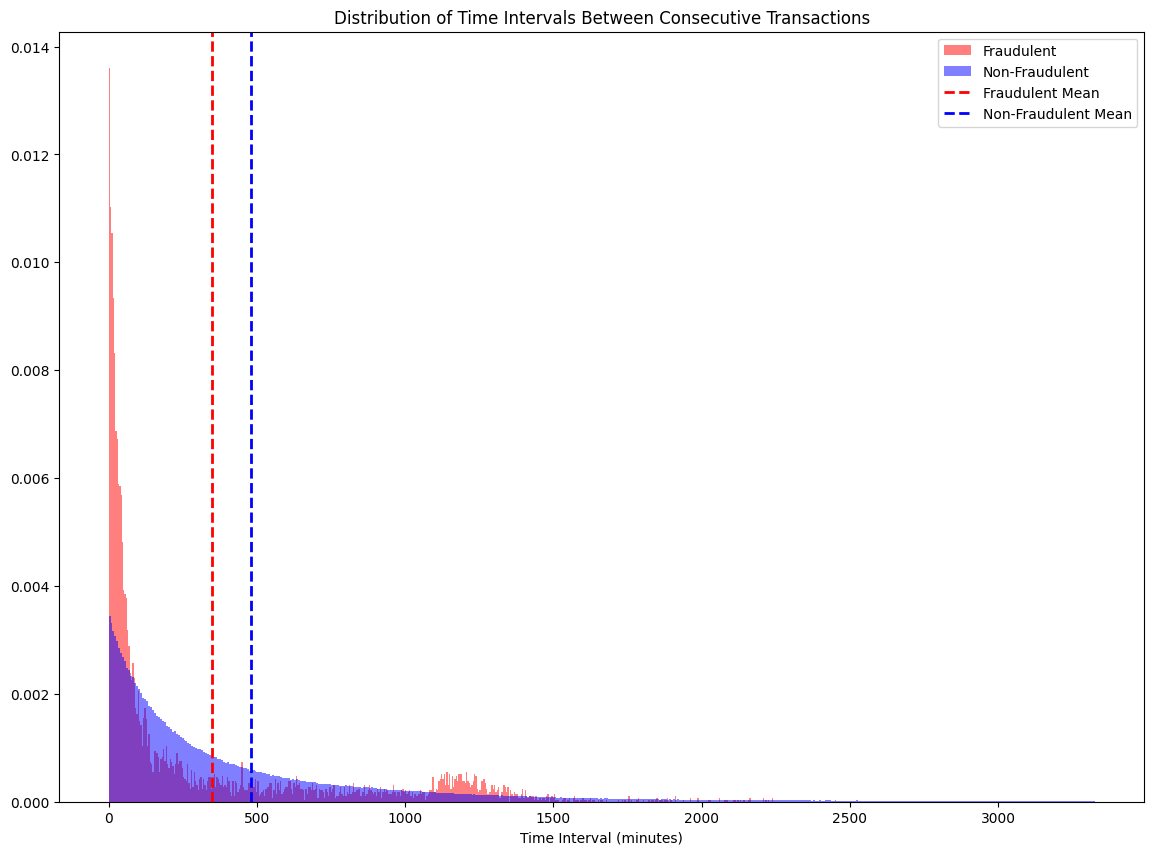

In [19]:
# Create the plot
plt.figure(figsize=(14, 10))

# Calculate Means
fraud_mean = fraud_intervals_df.mean()
non_fraud_mean = non_fraud_intervals_df.mean()


# Plot histograms
plt.hist(fraud_intervals_df, bins=500, alpha=0.5, color='red', label='Fraudulent', 
         density=True, range=(0, fraud_intervals_df.quantile(0.99)))
plt.hist(non_fraud_intervals_df, bins=500, alpha=0.5, color='blue', label='Non-Fraudulent', 
         density=True, range=(0, non_fraud_intervals_df.quantile(0.99)))

# Add means to plot
plt.axvline(fraud_mean, color='red', linestyle='dashed', linewidth=2, label='Fraudulent Mean')
plt.axvline(non_fraud_mean, color='blue', linestyle='dashed', linewidth=2, label='Non-Fraudulent Mean')

# Add labels and title
plt.xlabel('Time Interval (minutes)')
plt.title('Distribution of Time Intervals Between Consecutive Transactions')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [20]:
# Kolmogorov-Smirnov test

statistic, p_value = stats.ks_2samp(fraud_intervals_df, non_fraud_intervals_df)

print(f"Kolmogorov-Smirnov test statistic: {statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("There is no significant evidence that the distributions are different.")

Kolmogorov-Smirnov test statistic: 0.26787454917901615
p-value: 0.0
The distributions are significantly different.


## Additional Insights

### Fraud by by Category

**Analysis**

Analysis of fraudulent transactions by transaction category shows that certain categories are statistically more frequently attributed to fraudulent transactions. This is demonstrated through the chi-squared test as well as visually in the plots below. Fraudulent transactions appear to fall disproportionately into the grocery and shopping categories.


In [21]:
# Create dataframe of transaction by category

final_df['category'] = final_df['category'].str.lower()
category_df = final_df.groupby('category').agg(total_transactions=('trans_num','size'),fraud_count=('is_fraud','sum')).sort_values('fraud_count',ascending=False).reset_index()
category_df['fraud_percent'] = (category_df['fraud_count']/category_df['total_transactions'])*100
category_df['non_fraud_count'] = category_df['total_transactions'] - category_df['fraud_count']

In [22]:
category_df

,category,total_transactions,fraud_count,fraud_percent,non_fraud_count
0,grocery_pos,140534,1309.0,0.931447,139225.0
1,shopping_net,111984,1284.0,1.146592,110700.0
2,misc_net,72742,681.0,0.936185,72061.0
3,shopping_pos,134015,611.0,0.455919,133404.0
4,gas_transport,150168,455.0,0.302994,149713.0
5,misc_pos,91343,201.0,0.220050,91142.0
6,home,140277,198.0,0.141149,140079.0
7,kids_pets,129422,194.0,0.149897,129228.0
8,personal_care,104402,194.0,0.185820,104208.0
9,entertainment,106971,186.0,0.173879,106785.0


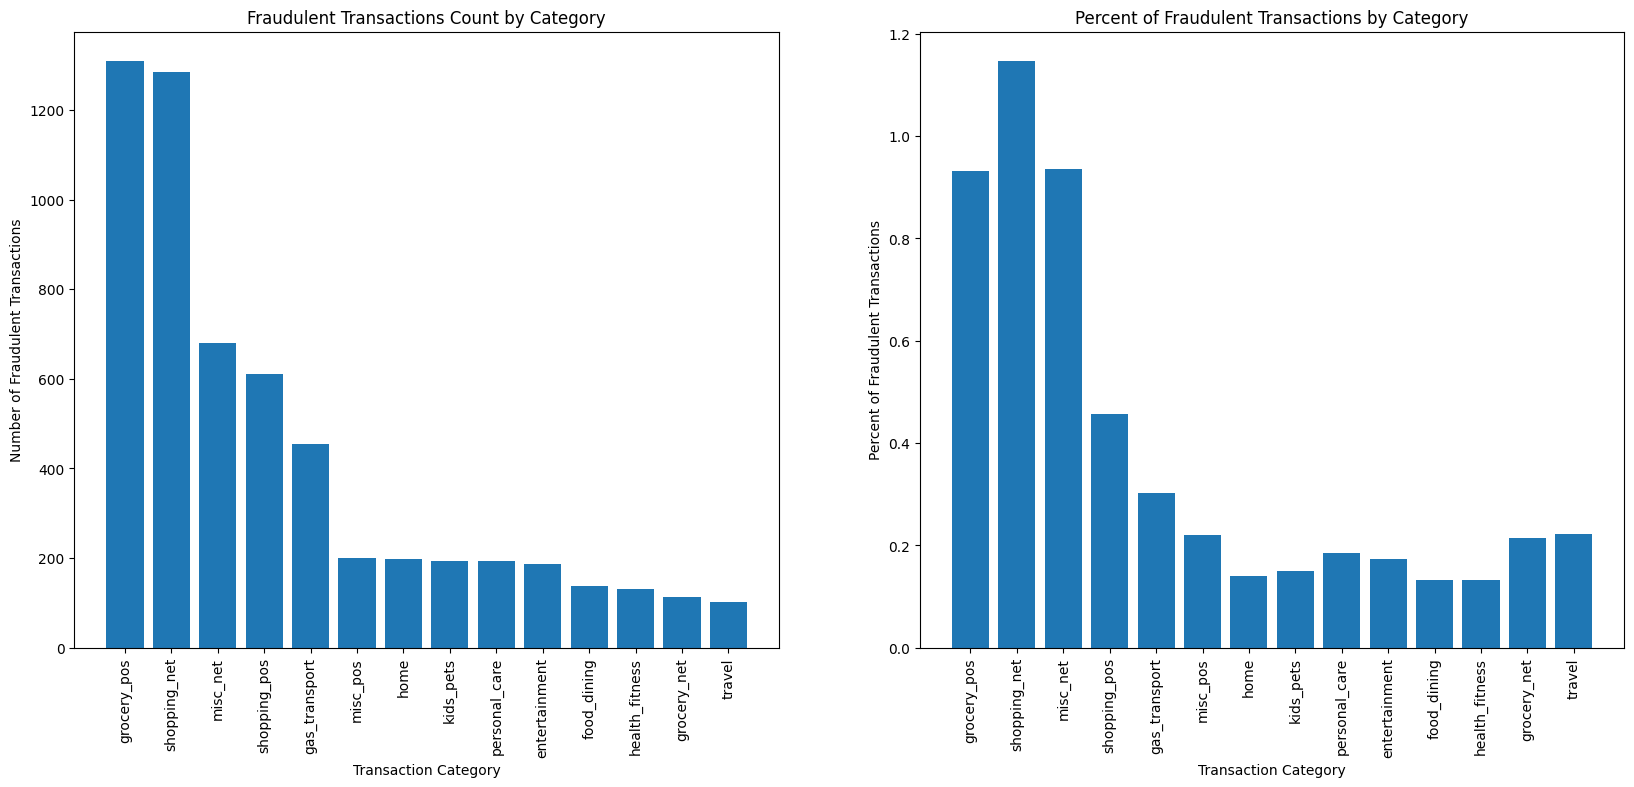

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plotting the first graph (Fraud Count)
axs[0].bar(category_df['category'], category_df['fraud_count'])
axs[0].set_xlabel('Transaction Category')
axs[0].set_ylabel('Number of Fraudulent Transactions')
axs[0].set_title('Fraudulent Transactions Count by Category')
axs[0].tick_params(axis='x', rotation=90)

# Plotting the second graph (Percent Fraud)
axs[1].bar(category_df['category'], category_df['fraud_percent'])
axs[1].set_xlabel('Transaction Category')
axs[1].set_ylabel('Percent of Fraudulent Transactions')
axs[1].set_title('Percent of Fraudulent Transactions by Category')
axs[1].tick_params(axis='x', rotation=90)

In [24]:
# Chi-square test

contingency_table = category_df[['fraud_count', 'non_fraud_count']].values
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

Chi-Square Statistic: 4446.750980463531
P-Value: 0.0


In [25]:

if p_value < 0.05:
    print("The relationship between transaction category and fraud occurrence is statistically significant.")
else:
    print("There is no statistically significant relationship between transaction category and fraud occurrence.")


The relationship between transaction category and fraud occurrence is statistically significant.


### Transaction Size

**Analysis**

It is clear that there is a difference between the distrubutions of transaction size for fraudulent and non-fraudulent transactions. This is also demonstrated statistically by the Kolmogorov-Smirnov test between the two distributions below. 

The average transaction size for non-fraudulent transactions was much smaller than that of fraudulent transactions as displayed in the plot below. The distribution of transaction size for non-fraudulent transactions was also much more narrow with a std of 15 compared to an std of 390 with fraudulent transactions. 

Further analysis could look into the variance of transaction size by customer for fraudulent and non-fraudulent transactions

In [26]:
# Create fraudulent and non-fraudulent transaction size data frames
fraud_transaction_size = final_df[final_df['is_fraud'] == 1]['amt']
non_fraud_transaction_size = final_df[final_df['is_fraud'] == 0]['amt']

In [27]:
fraud_transaction_size.describe()

count    6496.000000
mean      516.428608
std       390.196545
min         1.060000
25%       132.697500
50%       359.115000
75%       888.155000
max      1371.810000
Name: amt, dtype: float64

In [28]:
non_fraud_transaction_size.describe()

count    1.476376e+06
mean     6.763785e+01
std      1.508915e+02
min      1.000000e+00
25%      9.550000e+00
50%      4.680000e+01
75%      8.241000e+01
max      2.894890e+04
Name: amt, dtype: float64

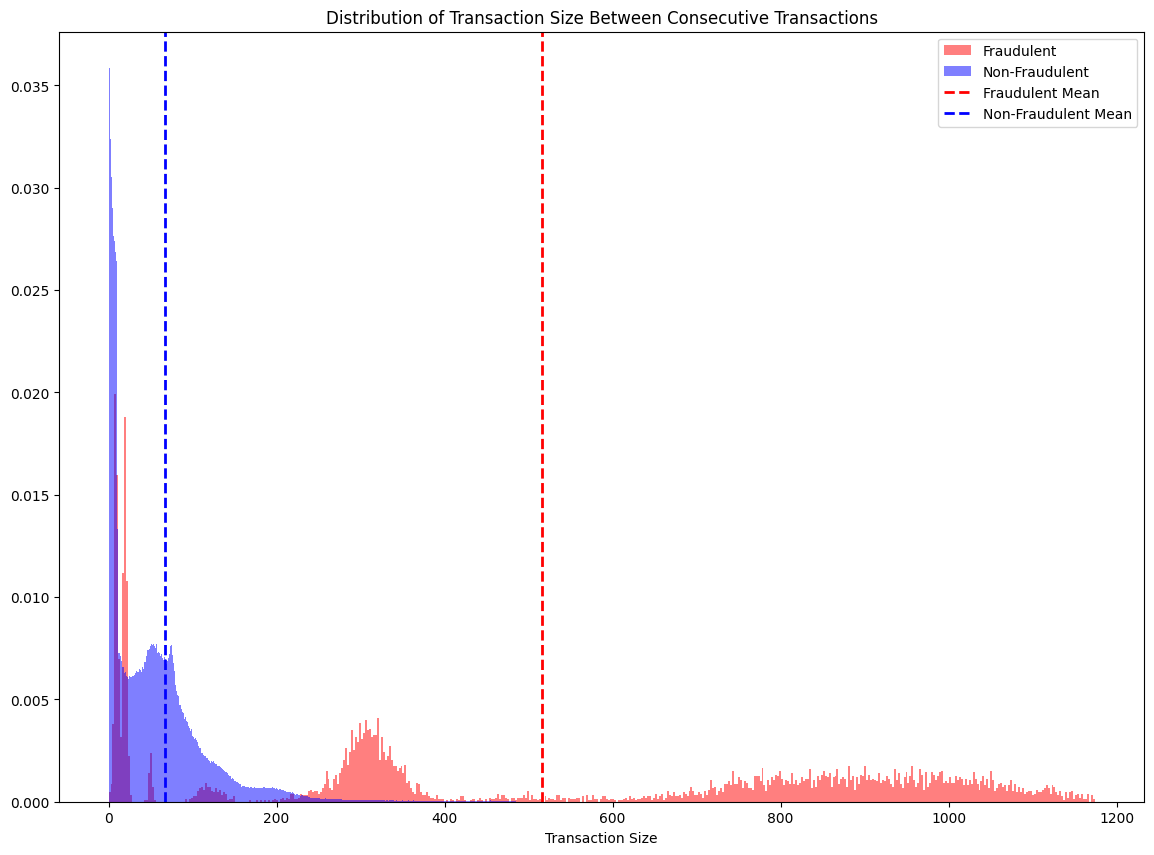

In [29]:
# Create the plot
plt.figure(figsize=(14, 10))

# Calculate Means
fraud_mean = fraud_transaction_size.mean()
non_fraud_mean = non_fraud_transaction_size.mean()


# Plot histograms
plt.hist(fraud_transaction_size, bins=500, alpha=0.5, color='red', label='Fraudulent', 
         density=True, range=(0, fraud_transaction_size.quantile(0.99)))
plt.hist(non_fraud_transaction_size, bins=500, alpha=0.5, color='blue', label='Non-Fraudulent', 
         density=True, range=(0, non_fraud_transaction_size.quantile(0.99)))

# Add means to plot
plt.axvline(fraud_mean, color='red', linestyle='dashed', linewidth=2, label='Fraudulent Mean')
plt.axvline(non_fraud_mean, color='blue', linestyle='dashed', linewidth=2, label='Non-Fraudulent Mean')

# Add labels and title
plt.xlabel('Transaction Size')
plt.title('Distribution of Transaction Size Between Consecutive Transactions')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [30]:
# Kolmogorov-Smirnov test

statistic, p_value = stats.ks_2samp(fraud_transaction_size, non_fraud_transaction_size)

print(f"Kolmogorov-Smirnov test statistic: {statistic}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("There is no significant evidence that the distributions are different.")

Kolmogorov-Smirnov test statistic: 0.7087149722442446
p-value: 0.0
The distributions are significantly different.
